# Pre-requisites

I ran this notebook using Google Colab. Therefore, I needed to install and load a few things like Torch. I also needed to create a mapped drive that I could read and write to via code in this notebook.


In [ ]:
# http://pytorch.org/
# Install Torch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
# Install Pillow and Image
!pip install Pillow==4.1.1
!pip install PIL
!pip install image

In [0]:
# Map the Google drive location
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# List all files and folders on this location to test that the Google drive mapping is working
import os
os.listdir("/content/gdrive/My Drive/PyTorch Project/MyData/")

# An AI application for image classification


I'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. For me, this is a proof of concept for. My plans are to extend this at some point in future and potentially use in real life use case of image classification like in the agricuture sector for predicting plant diseases. 

<img src='assets/Flowers.png' width=500px>

I will break down this project into the following steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

First up is importing the packages you'll need.

In [0]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import os, random
import json
import time
import copy
from collections import OrderedDict
from PIL import Image

import torch
import torchvision
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch import nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

## Loading my data

Using `torchvision` to load my data, I will split the dataset into three parts, training, validation and test. For the training, I will apply transformations that will help my network generalize leading to better performance. I will use a pre-trained network, hence the reason my input data is resized to 224x224 pixels as required by the networks.

I will use the validation set to measure my model's performance on data it hasn't seen yet. I wont apply any transformations on this dataset, but I'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For my sets, I'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# Setting my Google drive directory paths here

data_dir = '/content/gdrive/My Drive/PyTorch Project/MyData'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
# Defining my transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])

cost_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])
                                     ])


# Loading the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
cost_data = datasets.ImageFolder(valid_dir, transform=cost_transforms)
test_data  = datasets.ImageFolder(test_dir, transform=test_transforms)

# Defining the dataloaders using the image datasets and the transforms, 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(cost_data, batch_size=32)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=32)

image_datasets = [train_data, cost_data, test_data]
dataloaders = [train_loader, valid_loader, test_loader]

###  Mapping the labels

I'll also need to load in a mapping from category label to category name which will give me a dictionary that maps the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('/content/gdrive/My Drive/PyTorch Project/CategoryName.json', 'r') as f:
    CategoryName = json.load(f)
    
print(CategoryName)
print("\n Length:", len(CategoryName))

## Building the network

I will now build the network. In this case, I use a pre-trained vgg19 network from torchvision that's initially been trained on ImageNet dataset.

I will start with loading the pretrained network, and then define my new untrained feed-forward network classifier, applying ReLu activation and dropout.

In [0]:
# TODO: Build and train your network
# Load a pre-trained network
model = models.vgg19(pretrained=True)
model

for param in model.parameters():
    param.requires_grad = False

In [0]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout.# Defin 
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1024)),
                          ('drop', nn.Dropout(p=0.5)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.classifier.to(device)

## Training my classifier

Using the vgg19 network features from above, I will train its classifier layers using backpropagation, and then track the accuracy and loss when passing the validation set so that I can select the most accurate hyperparameters. During the training iteration, I will only be updating the weights of the feed-forward network. My hyperparameters will be the learning rate and epochs.

I will save the best hyperparameters to that I can reuse them later.

In [ ]:
# Training the classifier layers using backpropagation using the pre-trained network to get the features.
# Also tracking the loss and accuracy on the validation set to select the most accurate hyperparameters.

epochs = 10
steps = 0
running_loss = 0
accuracy = 0
best_accuracy = 0.0

# Defining criterion, optimizer and scheduler
# Observe that only parameters that require gradients are optimized
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

cuda = torch.cuda.is_available()

best_model_wts = copy.deepcopy(model.state_dict())

start = time.time()
if cuda:
    print('Training started on GPU')
    model.cuda()
else:
    print('Training started on CPU')
    model.cpu()

for e in range(epochs):
    
    train_mode = 0
    valid_mode = 1
    
    for mode in [train_mode, valid_mode]:   
        if mode == train_mode:
            model.train()
        else:
            model.eval()
            
        pass_count = 0
        
        for data in dataloaders[mode]:
            pass_count += 1
            inputs, labels = data
            if cuda == True:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()
            # Forward
            output = model.forward(inputs)
            loss = criterion(output, labels)
            # Backward
            if mode == train_mode:
                loss.backward()
                optimizer.step()                
            
            running_loss += loss.item()
            ps = torch.exp(output).data
            equality = (labels.data == ps.max(1)[1])
            accuracy = equality.type_as(torch.cuda.FloatTensor()).mean()

        if mode == train_mode:
            print("\nEpoch: {}/{} ".format(e+1, epochs),
                  "\nTraining Loss: {:.4f}  ".format(running_loss/pass_count),
                 "Accuracy: {:.4f}".format(accuracy))
        else:
            print("Validation Loss: {:.4f}  ".format(running_loss/pass_count),
              "Accuracy: {:.4f}".format(accuracy))

        running_loss = 0
                
        time_elapsed = time.time() - start
        
        # Saving the best hyperparemeters
        if mode == valid_mode and accuracy > best_accuracy:
            print('Validation accurancy increased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_accuracy, accuracy))
            best_accuracy = accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            
        if mode == valid_mode:
            print('Training time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

time_elapsed = time.time() - start
print("\nTotal time: {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_accuracy))

# Load best model weights
model.load_state_dict(best_model_wts)

## Testing classification accuracy

Using the most accurate hyperparameters and weights I had managed to save, I will run it on my test dataset which the model has never seen before and print out its accuracy.

In [21]:
# Testing my best saved hyperparameters and weights' accuracy
model.eval()
TestAccuracy = 0
cuda = torch.cuda.is_available()

if cuda:
    model.cuda()
else:
    model.cpu()
    
pass_count = 0

for data in dataloaders[2]:
    pass_count += 1
    images, labels = data
    
    if cuda == True:
        images, labels = Variable(images.cuda()), Variable(labels.cuda())
    else:
        images, labels = Variable(images), Variable(labels)

    output = model.forward(images)
    ps = torch.exp(output).data
    equality = (labels.data == ps.max(1)[1])
    TestAccuracy += equality.type_as(torch.FloatTensor()).mean()

print("Testing Accuracy: {:.4f}".format(TestAccuracy/pass_count))

Testing Accuracy: 0.9003


## Creating and saving a checkpoint


I will now save my model so that I can load it in future when making predictions. By doing this, it means I wont need to run all of the code before this point, I can simply come back and load this saved model and carry on with predictions. I will also take this opportunity to save any other information that I might need in future.

In [0]:
# Checkpoint path where my model will be saved
checkpoint_path = '/content/gdrive/My Drive/PyTorch Project/model_checkpoint_v3.pth'

# Attaching class_to_idx to the model as an attribute for future inference
model.class_to_idx = image_datasets[0].class_to_idx

# Saving additional information to the checkpoint for future use
checkpoint = {'input_size': 25088,
              'output_size': 102,
              'arch': 'vgg19',
              'learning_rate': 0.01,
              'batch_size': 64,
              'classifier' : classifier,
              'epochs': epochs,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx}

# Finally saving my checkpoint
torch.save(checkpoint, checkpoint_path)

## Load checkpoint

I will define a function that I can always call to load my saved checkpoint and rebuild my model so that I don't have to retrain my network

In [0]:
# Function for loading the checkpoint and rebuilding my model

def load_checkpoint(checkpoint_path):
  
    checkpoint = torch.load(checkpoint_path)
    
    # Load my pre-trained network
    model = models.vgg19(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False       
        
    # Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout. 
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(25088, 1024)),
                              ('drop', nn.Dropout(p=0.5)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(1024, 102)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    return model

### Check model architecture

This is optional, I just want to check that the network architecture of my loaded checkpoint and rebuilt model looks right.

In [0]:
checkpoint_path = '/content/gdrive/My Drive/PyTorch Project/model_checkpoint_v3.pth'
model = load_checkpoint(checkpoint_path)
checkpoint_model = print(model)

## Preprocessing images

Using `PIL` to load the image, I will write a function that will process the image so that my network can actually use it as input into my model, similar to how I had processed the images during training.

I will resize the images where the shortest side is 256 pixels, keeping the aspect ratio, before I crop out the center 224x224 portion of the image.

Using a Numpy array which I will get from PIL image (`np_image = np.array(pil_image)`), I will convert my color channel values from the typical 0-255 integers to 0-1 floats which is what the model expects. 

I wil then normalise the images as expected by my network by getting the difference between the color channels and the means, and then divide the difference by the standard deviation.

Lastly, I will re-order the color channel to be the first dimension in the Numpy array and PIL image as expected by PyTorch, and then retain the order of the two remaining dimensions.

In [0]:
# Function scales, crops, and normalizes a PIL image for a PyTorch model and returns an Numpy array

def process_image(image):
    # Now processing the PIL image for use in a PyTorch model
    
    img_loader = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor()])
    
    pil_image = Image.open(image)
    pil_image = img_loader(pil_image).float()
    
    np_image = np.array(pil_image)    
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np.transpose(np_image, (1, 2, 0)) - mean)/std    
    np_image = np.transpose(np_image, (2, 0, 1))
            
    return np_image

### Show processed image

Just to make sure that the image processing function works, the below function will display the original image  withouth the cropped sections, after converting the PyTorch tensor.

In [0]:
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.transpose(image, (1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

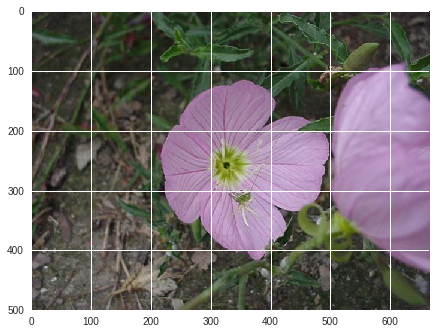

In [16]:
img = random.choice(os.listdir('/content/gdrive/My Drive/PyTorch Project/MyData/train/1/'))
img_path = '/content/gdrive/My Drive/PyTorch Project/MyData/train/1/' + img

with Image.open(img_path) as image:
    plt.imshow(image)

## Class Prediction (and Inferencing)

I will now write the function that now actually does the predictions using a trained deep learning model. I will predict the `topk` (top 5) most probable classes and I'll calculate the class probabilities, then find the `k` largest values.

I will retain both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I will use `class_to_idx`, which I had added to the model when saving the checkpoint, to convert the indices to actual class lables, and ensure that I have inverted the dictionary so that I get a mapping from from index to class too.

In [0]:
# Function to predict the class from an image file using a trained deep learning model.
    
def predict(image_path, checkpoint_path, topk=5):

    # Load the checkpoint
    model = load_checkpoint(checkpoint_path)
    
    # Use gpu if selected and available
    if torch.cuda.is_available():
        print("Number of GPUs:", torch.cuda.device_count())
        print("Device name:", torch.cuda.get_device_name(torch.cuda.device_count()-1))
        device = torch.device("cuda:0")
        model.cuda()
    else:
        print('Using CPU for predicting')
        device = torch.device("cpu")
    
    # turn off dropout
    model.eval()

    # The image
    image = process_image(image_path)
    
    # tranfer to tensor
    image = torch.from_numpy(np.array([image])).float()
    
    # The image becomes the input
    image = Variable(image)
    if torch.cuda.is_available():
        image = image.cuda()
        
    output = model.forward(image)
    
    probabilities = torch.exp(output).data
    
    # getting the topk (=5) probabilites and indexes
    # 0 -> probabilities
    # 1 -> index
    prob = torch.topk(probabilities, topk)[0].tolist()[0] # probabilities
    index = torch.topk(probabilities, topk)[1].tolist()[0] # index
    
    ind = []
    for i in range(len(model.class_to_idx.items())):
        ind.append(list(model.class_to_idx.items())[i][0])

    # transfer index to label
    label = []
    for i in range(5):
        label.append(ind[index[i]])

    return prob, label

### Call prediction function

I will now call the prediction function which takes in a path to an image and a model checkpoint, return the probabilities and classes, and then print them out.

```python
probs, classes = predict(image_path, checkpoint_path)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
# Initialising the variables for the path of the saved checkpoint 
# and randomly picking the image sample to predict its name
checkpoint_path = '/content/gdrive/My Drive/PyTorch Project/model_checkpoint_v3.pth'
img = random.choice(os.listdir('/content/gdrive/My Drive/PyTorch Project/MyData/train/2/'))
image_path = '/content/gdrive/My Drive/PyTorch Project/MyData/train/2/' + img


# Now calling the prediction on a sample image and retaining the probabilities and classes
probs, classes = predict(image_path, checkpoint_path)
print(probs)
print(classes)
print([CategoryName[x] for x in classes])



## Rationality Check

So just in case I has a high test accuracy, I just need to counter check that yes, the prediction is actually true. So I will use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. I also convert the class integrers to the actual image names using my `CategoryName.json` file, and the use the function `imshow` to display the original image as well.

In [0]:
# Function will display an image with top 5 classes

def check_sanity(image_path, prob, classes):
    max_index = np.argmax(prob)
    max_probability = prob[max_index]
    label = classes[max_index]

    fig = plt.figure(figsize=(6,6))
    ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
    ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

    image = Image.open(image_path)
    ax1.axis('off')
    ax1.set_title(CategoryName[label])
    ax1.imshow(image)

    labels = []
    for cl in classes:
        labels.append(CategoryName[cl])

    y_pos = np.arange(5)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.set_xlabel('Probability')
    ax2.invert_yaxis()
    ax2.barh(y_pos, prob, xerr=0, align='center', color='blue')

    plt.show()

Number of GPUs: 1
Device name: Tesla K80


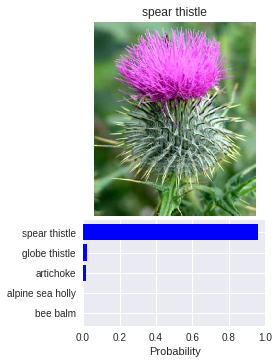

In [40]:
checkpoint_path = '/content/gdrive/My Drive/PyTorch Project/model_checkpoint_v3.pth'
img = random.choice(os.listdir('/content/gdrive/My Drive/PyTorch Project/MyData/test/14/'))
image_path = '/content/gdrive/My Drive/PyTorch Project/MyData/test/14/' + img


probs, classes = predict(image_path, checkpoint_path)
check_sanity(image_path, probs, classes)

# Conclusion

And that's it, for now. This has been my first image classification model that I ever created. I will now be aiming to extend it to other potential use cases and I would like to train it on different datasets and see the results. Should be fun!

I would like to thank Udacity and Facebook AI for giving me the opportunity to study 'Introduction to Deep Learning using PyTorch' during the Facebook AI Scholarship Challenge, where I picked up the necessary Artificial Intelligence coding skills to reach this far.